# Analyzing PBMCs of Covid patients and healthy controls

## Load libraries

In [148]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import harmonypy
import gseapy

Creating directory C:\Users\bende\AppData\Local\bioservices\bioservices 


## Load the data

Make sure we are in the correct working directory

In [2]:
os.getcwd() #get current working directory

'C:\\Users\\bende\\Documents\\S3++_project\\DDD_disk\\notebooks'

In [3]:
# change working directory
os.chdir('C:\\Users\\bende\\Documents\\S3++_project\\DDD_disk')

### load files

In [4]:
# Load count matrices for all samples (cells by genes)
adata_cov1 = sc.read_10x_h5("data/nCoV_PBMC_1.h5")
adata_cov2 = sc.read_10x_h5("data/nCoV_PBMC_15.h5")
adata_cov3 = sc.read_10x_h5("data/nCoV_PBMC_17.h5")
adata_norm1 = sc.read_10x_h5("data/Normal_PBMC_13.h5")
adata_norm2 = sc.read_10x_h5("data/Normal_PBMC_14.h5")
adata_norm3 = sc.read_10x_h5("data/Normal_PBMC_5.h5")

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\readwrite.py:281: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndat

In [5]:
# Make variable names (gene names) unique
adata_cov1.var_names_make_unique()
adata_cov2.var_names_make_unique()
adata_cov3.var_names_make_unique()
adata_norm1.var_names_make_unique()
adata_norm2.var_names_make_unique()
adata_norm3.var_names_make_unique()

### set condition

In [6]:
adata_cov1.obs["sample"] = "cov1"
adata_cov2.obs["sample"] = "cov2"
adata_cov3.obs["sample"] = "cov3"
adata_norm1.obs["sample"] = "norm1"
adata_norm2.obs["sample"] = "norm2"
adata_norm3.obs["sample"] = "norm3"

In [7]:
adata_cov1.obs["condition"] = "covid"
adata_cov2.obs["condition"] = "covid"
adata_cov3.obs["condition"] = "covid"
adata_norm1.obs["condition"] = "control"
adata_norm2.obs["condition"] = "control"
adata_norm3.obs["condition"] = "control"

Concatenate all objects (combine adata objects into one)

In [8]:
adata = adata_cov1.concatenate(adata_cov2, adata_cov3,
                      adata_norm1, adata_norm2,
                      adata_norm3)

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [9]:
#check our whole data
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'sample', 'condition', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

## Preprocessing

### QC

#### recording count depth, gene number and mitchondrial fraction

In [10]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

In [11]:
#write list for each gene, containing True if it's mitochondrial
mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]

In [12]:
#convert from sparse matrix to array
adata.X = adata.X.toarray()

In [13]:
adata.obs['mt_frac'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

#### plotting QC metrics

##### violin plot

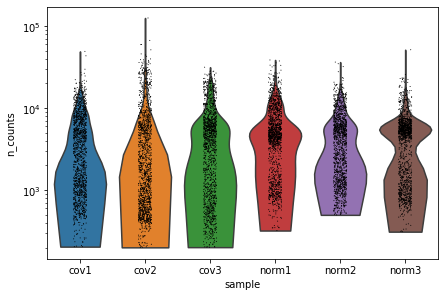

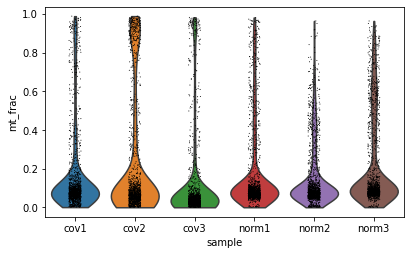

In [14]:
t1 = sc.pl.violin(adata, 'n_counts', groupby ='sample', size = 1, log = True, cut = 0)
t2 = sc.pl.violin(adata, 'mt_frac', groupby = 'sample')

##### scatter plot

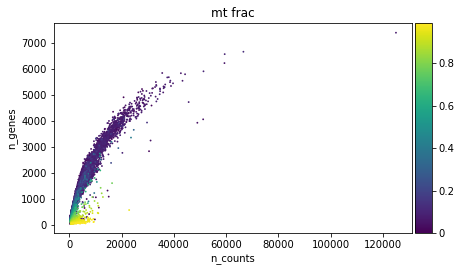

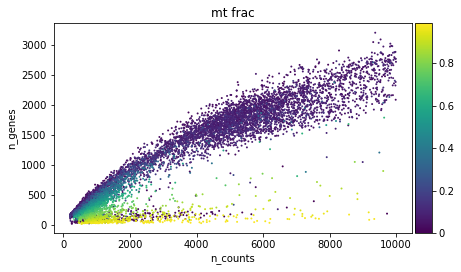

In [15]:
#all data
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
#count depth smaller than 1000
p2 = sc.pl.scatter(adata[adata.obs['n_counts']<10000], 'n_counts', 'n_genes', color='mt_frac')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


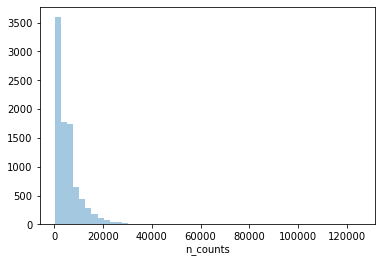

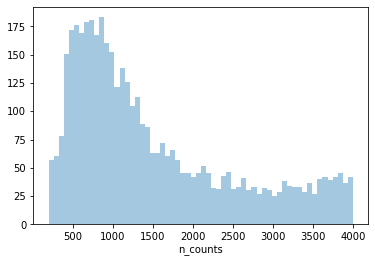

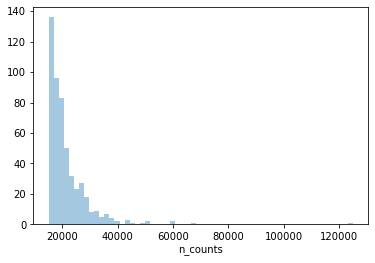

In [16]:
#Thresholding decision: counts
p3 = sb.distplot(adata.obs['n_counts'], kde = False)
plt.show()

p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<4000], kde = False, bins = 60)
plt.show()

p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>15000], kde = False, bins = 60)
plt.show()

the better the distribution fits real data, the better the whole statistical analysis is going to be

#### identifying thresholds and reducing data

##### manual all samples

In [17]:
n_counts_upper_1 = 32000
n_counts_upper_2 = 25000

n_counts_lower = 450

n_genes_lower_1 = 150
n_genes_lower_2 = 200

mt_frac_lower = 0.2

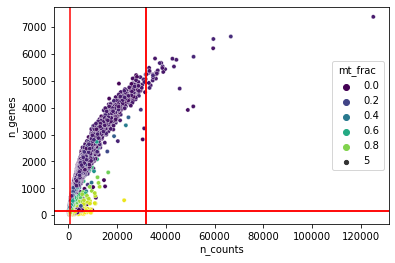

In [18]:
sb.scatterplot(data = adata.obs, 
               x = 'n_counts', 
               y = 'n_genes', 
               hue = 'mt_frac', 
               palette = 'viridis',
               size = 5
              )

plt.axvline(x = n_counts_upper_1, c = 'red')
plt.axvline(x = n_counts_upper_1, c = 'red')
plt.axvline(x = n_counts_lower, c = 'red')

plt.axhline(y = n_genes_lower_1, c = 'red')
plt.axhline(y = n_genes_lower_1, c = 'red')

In [19]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

adata_flt_all_man = adata[adata.obs['n_counts'] < n_counts_upper_1, :]
print(adata_flt_all_man.n_obs)

adata_flt_all_man = adata_flt_all_man[adata_flt_all_man.obs['n_counts'] > n_counts_lower, :]
print(adata_flt_all_man.n_obs)

adata_flt_all_man = adata_flt_all_man[adata_flt_all_man.obs['mt_frac'] < mt_frac_lower, :]
print(adata_flt_all_man.n_obs)

adata_flt_all_man = adata_flt_all_man[adata_flt_all_man.obs['n_genes'] > n_genes_lower_1, :]
print(adata_flt_all_man.n_obs)

Total number of cells: 9000
8965
8638
6732
6513


In [20]:
adata_flt_all_man

View of AnnData object with n_obs × n_vars = 6513 × 33538
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sample_colors'

##### auto all samples

In [129]:
def determine_threshold (adata, n = 3, mode = 'mad', min = True, max = True, n_gene_tresh = True):
    if mode == 'mad':
        if min:
            min_threshold = np.median(adata.obs['log_counts']) - n * np.median(np.absolute(adata.obs['log_counts'] - np.median(adata.obs['log_counts'])))
        if max:
            max_threshold = np.median(adata.obs['log_counts']) + n * np.median(np.absolute(adata.obs['log_counts'] - np.median(adata.obs['log_counts'])))
        if n_gene_tresh:
            min_n_genes_tresh = np.median(adata.obs['log_counts']) - n * np.median(np.absolute(adata.obs['log_counts'] - np.median(adata.obs['log_counts'])))
        return min_threshold, max_threshold, min_n_genes_tresh

In [130]:
def qc_count (adata, min = True, max = True, min_n_genes = True, mt = False, max_mt_frac = None, n = 3):
    if min:
        min_value = determine_threshold(adata, n = n)[0]
        print('min_log_value: ' + str(min_value))
        print('min_value: ' + str(np.exp(min_value)))
        adata = adata[adata.obs['log_counts'] > min_value, :]
        print ('size: ' + str(adata.shape))
    if max:
        max_value = determine_threshold(adata, n = n)[1]
        print('max_log_value: ' + str(max_value))
        print('max_value: ' + str(np.exp(max_value)))
        adata = adata[adata.obs['log_counts'] < max_value, :]
        print ('size: ' + str(adata.shape))
    if min_n_genes:
        min_n_genes_value = determine_threshold(adata, n = n)[2]
        print('min_gene_log_value: ' + str(max_value))
        print('min_gene_value: ' + str(np.exp(max_value)))
        adata = adata[adata.obs['log_counts'] > min_n_genes_value, :]
        print ('size: ' + str(adata.shape))
    if mt:
        adata = adata[adata.obs['mt_frac'] < max_mt_frac, :]
        print ('size: ' + str(adata.shape))
    return adata

In [131]:
adata_flt_all_auto = qc_count(adata, mt = True, max_mt_frac = 0.2)

min_log_value: 5.9967756271362305
min_value: 402.1300835262991
size: (8784, 33538)
max_log_value: 10.657384395599365
max_value: 42505.31456145271
size: (8773, 33538)
min_gene_log_value: 10.657384395599365
min_gene_value: 42505.31456145271
size: (8630, 33538)
size: (6730, 33538)


In [132]:
adata_flt_all_auto

View of AnnData object with n_obs × n_vars = 6730 × 33538
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'sample_colors'

##### manual per sample

In [133]:
threshold_dict = {
    "cov1":{"n_counts_lower_1":450,
            "n_counts_lower_2":700,
            
            "n_counts_upper_1":18000,
            "n_counts_upper_2":19000,
            
            "n_genes_lower_1":150,
            "n_genes_lower_2":300,
            
            "mt_fraq":0.2,
           },
    "cov2":{"n_counts_lower_1":400,
            "n_counts_lower_2":np.nan,
            
            "n_counts_upper_1":20000,
            "n_counts_upper_2":25000,
            
            "n_genes_lower_1":250,
            "n_genes_lower_2":np.nan,
            
            "mt_fraq":0.2,
           },
    "cov3":{"n_counts_lower_1":800,
            "n_counts_lower_2":np.nan,
            
            "n_counts_upper_1":10000,
            "n_counts_upper_2":7500,
            
            "n_genes_lower_1":100,
            "n_genes_lower_2":np.nan,
            
            "mt_fraq":0.1,
           },
    "norm1":{"n_counts_lower_1":800,
            "n_counts_lower_2":np.nan,
            
            "n_counts_upper_1":6500,
            "n_counts_upper_2":8500,
            
            "n_genes_lower_1":200,
            "n_genes_lower_2":np.nan,
            
            "mt_fraq":0.2,
           },
    "norm2":{"n_counts_lower_1":750,
            "n_counts_lower_2":np.nan,
            
            "n_counts_upper_1":18000,
            "n_counts_upper_2":np.nan,
            
            "n_genes_lower_1":350,
            "n_genes_lower_2":250,
            
            "mt_fraq":0.2,
           },
    "norm3":{"n_counts_lower_1":3000,
            "n_counts_lower_2":500,
            
            "n_counts_upper_1":20000,
            "n_counts_upper_2":np.nan,
            
            "n_genes_lower_1":350,
            "n_genes_lower_2":100,
            
            "mt_fraq":0.2,
           }
    
}

cov1
cov2
cov3
norm1


C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


norm2
norm3


C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\330154565.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


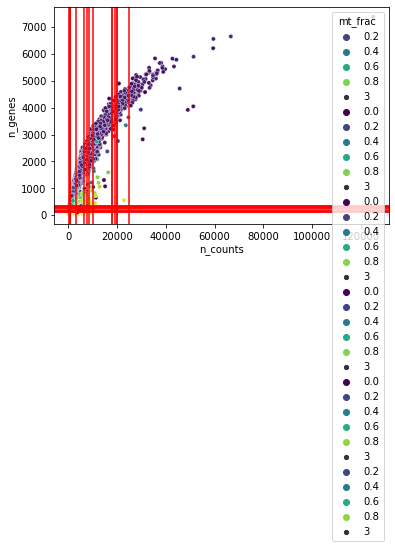

In [134]:
for samp in threshold_dict.keys():
    
    print(samp)
    
    adata_sub = adata[adata.obs['sample']==samp]
    sb.scatterplot(data=adata_sub.obs,
                   x='n_counts',
                   y='n_genes',
                   hue='mt_frac',
                   palette="viridis",
                   size=3
                  )
    #n_counts_upper
    plt.axvline(x=threshold_dict[samp]["n_counts_upper_1"], c="red")
    if not np.isnan(threshold_dict[samp]["n_counts_upper_2"]):
        plt.axvline(x=threshold_dict[samp]["n_counts_upper_2"], c="red")
    
    #n_counts_lower
    plt.axvline(x=threshold_dict[samp]["n_counts_lower_1"], c="red")
    if not np.isnan(threshold_dict[samp]["n_counts_lower_2"]):
        plt.axvline(x=threshold_dict[samp]["n_counts_lower_2"], c="red")
    
    #n_genes_lower
    plt.axhline(y=threshold_dict[samp]["n_genes_lower_1"], c="red")
    if not np.isnan(threshold_dict[samp]["n_genes_lower_2"]):
        plt.axhline(y=threshold_dict[samp]["n_genes_lower_2"], c="red")
    
    plt.show()

##### auto per sample

cov1
cov2
cov3
norm1
norm2
norm3


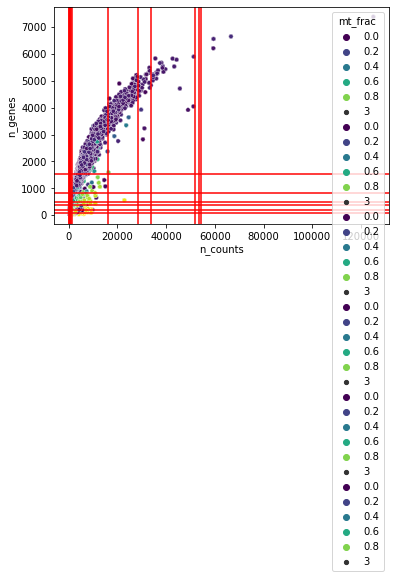

In [135]:
for samp in threshold_dict.keys():
    
    print(samp)
    
    adata_sub = adata[adata.obs['sample']==samp]
    
    min_threshold, max_threshold, min_ngenes_threshold = determine_threshold(adata_sub)
    
    sb.scatterplot(data=adata.obs,
                   x='n_counts',
                   y='n_genes',
                   hue='mt_frac',
                   palette="viridis",
                   size=3
                  )
    #n_counts_upper
    plt.axvline(x=np.exp(max_threshold), c="red")
    
    #n_counts_lower
    plt.axvline(x=np.exp(min_threshold), c="red")
    
    #n_genes_lower
    plt.axhline(y=np.exp(min_ngenes_threshold), c="red")
    
    #plt.show()

cov1
cov2
cov3


C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


norm1
norm2
norm3


C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_6772\2821718735.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


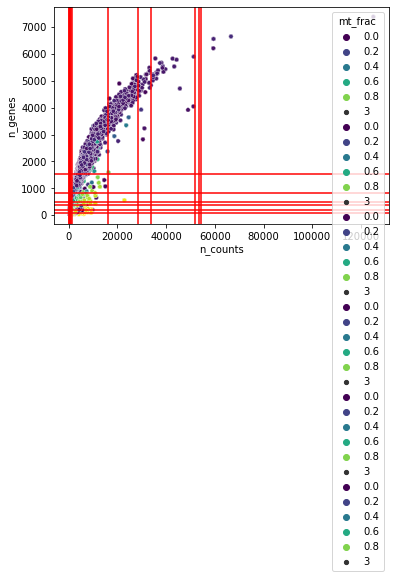

In [136]:
for samp in threshold_dict.keys():
    
    print(samp)
    
    adata_sub = adata[adata.obs['sample']==samp]
    
    min_threshold, max_threshold, min_ngenes_threshold = determine_threshold(adata_sub)
    
    sb.scatterplot(data=adata.obs,
                   x='n_counts',
                   y='n_genes',
                   hue='mt_frac',
                   palette="viridis",
                   size=3
                  )
    #n_counts_upper
    plt.axvline(x=np.exp(max_threshold), c="red")
    
    #n_counts_lower
    plt.axvline(x=np.exp(min_threshold), c="red")
    
    #n_genes_lower
    plt.axhline(y=np.exp(min_ngenes_threshold), c="red")
    
    plt.show()

#### gene reduction

In [21]:
sc.pp.filter_genes(adata_flt_all_man, min_cells = 20)

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [22]:
adata_flt_all_man

AnnData object with n_obs × n_vars = 6513 × 14047
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'sample_colors'

### normalization

In [23]:
# save raw counts in a new layer
adata_flt_all_man.layers['raw'] = adata_flt_all_man.X.copy()

In [24]:
sc.pp.normalize_per_cell(adata_flt_all_man, counts_per_cell_after = 10e4)
# counts_per_cell_after: originally, counts per gene would add up to one per cell
# this way we have larger numbers

### doublet detection

In [25]:
sc.external.pp.scrublet(adata_flt_all_man, batch_key = 'sample')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.3%
Estimated detectable doublet fraction = 25.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.2%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.8%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.33
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 38.8%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 0.9%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.32
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 35.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.9%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.23
Detected doublet rate = 3.7%
Estimated detectable doublet fraction = 41.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.8%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.33
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 24.5%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.9%


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


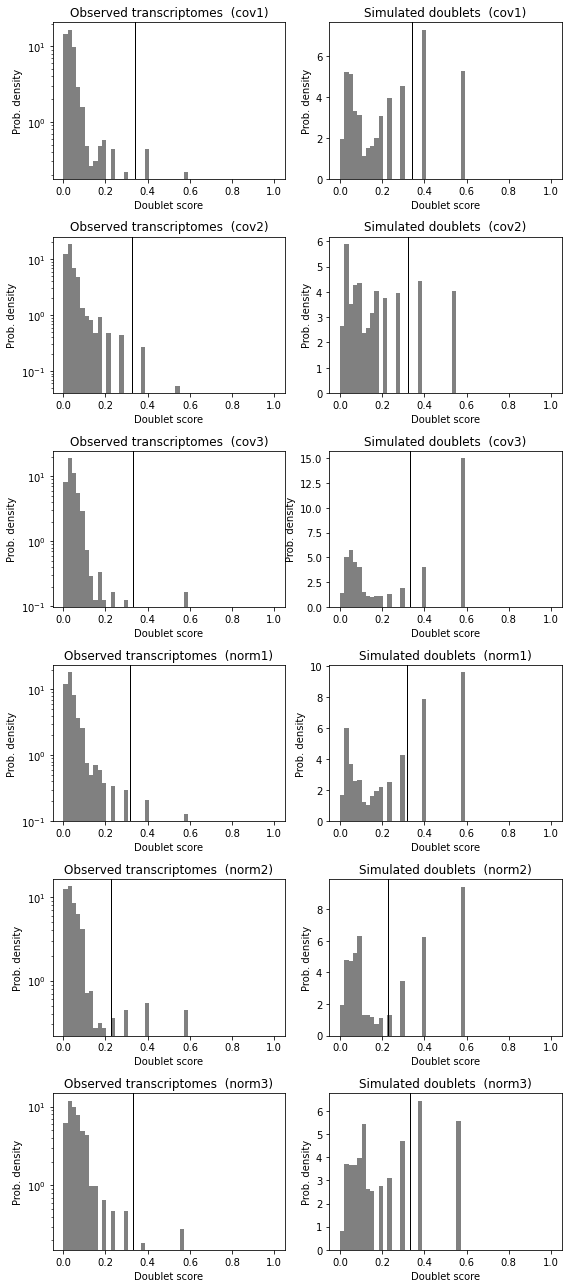

In [26]:
sc.external.pl.scrublet_score_distribution(adata_flt_all_man)

In [28]:
sum(adata_flt_all_man.obs['predicted_doublet'])

83

In [34]:
adata_flt_all_man = adata_flt_all_man[adata_flt_all_man.obs['predicted_doublet'] == False,:].copy()

In [35]:
adata_flt_all_man

AnnData object with n_obs × n_vars = 6430 × 14047
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'sample_colors', 'scrublet'
    layers: 'raw'

### log transform

(array([1.1631841e+07, 6.3608000e+04, 1.2138000e+04, 3.7780000e+03,
        1.6230000e+03, 1.0020000e+03, 8.8700000e+02, 7.8900000e+02,
        6.8100000e+02, 6.0100000e+02, 4.4400000e+02, 2.9700000e+02,
        2.1600000e+02, 1.3400000e+02, 9.9000000e+01, 1.0500000e+02,
        6.0000000e+01, 7.0000000e+01, 5.0000000e+01, 4.7000000e+01,
        2.9000000e+01, 4.3000000e+01, 2.8000000e+01, 3.1000000e+01,
        3.0000000e+01, 2.3000000e+01, 2.7000000e+01, 1.6000000e+01,
        2.2000000e+01, 1.1000000e+01, 1.0000000e+01, 8.0000000e+00,
        1.2000000e+01, 9.0000000e+00, 9.0000000e+00, 5.0000000e+00,
        1.3000000e+01, 4.0000000e+00, 6.0000000e+00, 7.0000000e+00,
        3.0000000e+00, 2.0000000e+00, 4.0000000e+00, 4.0000000e+00,
        3.0000000e+00, 1.0000000e+00, 2.0000000e+00, 2.0000000e+00,
        0.0000000e+00, 3.0000000e+00, 1.0000000e+00, 2.0000000e+00,
        5.0000000e+00, 0.0000000e+00, 2.0000000e+00, 4.0000000e+00,
        1.0000000e+00, 6.0000000e+00, 2.0000000e

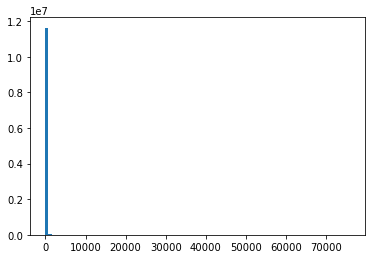

In [36]:
plt.hist(adata_flt_all_man.X.flatten()[adata_flt_all_man.X.flatten() > 0], bins = 100)

In [37]:
sc.pp.log1p(adata_flt_all_man)

C:\Users\bende\AppData\Local\Temp\ipykernel_10648\2182455648.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


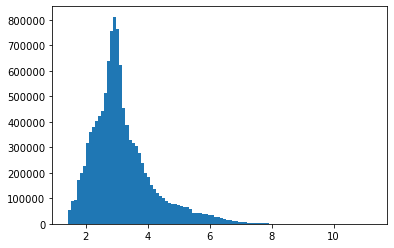

In [38]:
plt.hist(adata_flt_all_man.X.flatten()[adata_flt_all_man.X.flatten() > 0], 100)
plt.show()

### feature selection

select highly variable genes

test seurat vs. cell_ranger

In [39]:
sc.pp.highly_variable_genes(adata_flt_all_man, flavor = 'seurat')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_10648\1139004670.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


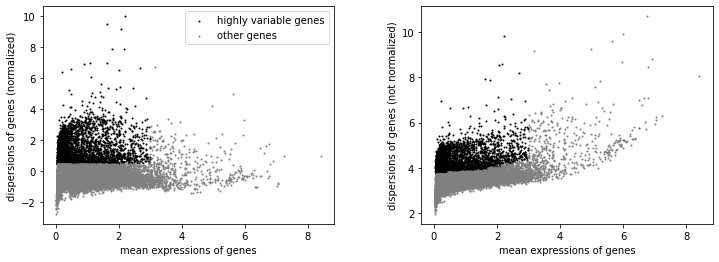

In [40]:
sc.pl.highly_variable_genes(adata_flt_all_man)
plt.show()

sc.pp.highly_variable_genes(adata_flt_all_man, flavor = 'cell_ranger')

sc.pl.highly_variable_genes(adata_flt_all_man)
plt.show()

In [41]:
adata_flt_all_man

AnnData object with n_obs × n_vars = 6430 × 14047
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_colors', 'scrublet', 'log1p', 'hvg'
    layers: 'raw'

In [42]:
sum(adata_flt_all_man.var['highly_variable'])

2947

### dimension reduction

In [43]:
sc.pp.pca(adata_flt_all_man, use_highly_variable = True)

In [44]:
adata_flt_all_man.obsm['X_pca'] = adata_flt_all_man.obsm['X_pca']

### visualization

In [45]:
adata_flt_all_man.obsm['X_pca']

array([[ -3.821795  ,  -1.1179072 ,  -7.092928  , ...,   2.0231855 ,
          1.0879639 ,   0.4241193 ],
       [ 17.965406  ,  -2.9990602 ,   0.98878455, ...,  -0.36521986,
          1.5883878 ,   0.38535494],
       [ 16.670694  ,   5.3514056 ,  -0.32664517, ...,   1.3461535 ,
         -2.876925  ,   0.34311992],
       ...,
       [ -7.9780836 ,  -4.001003  , -11.574379  , ...,   1.4560213 ,
         -1.7261198 ,   0.501011  ],
       [ -7.258409  ,  -3.0041368 , -10.37064   , ...,   0.65895444,
         -2.8064177 ,  -1.6317227 ],
       [-10.496639  ,  -1.8434315 ,   3.8843405 , ...,   1.4753155 ,
          2.5909262 ,   0.17153724]], dtype=float32)

In [46]:
sc.pp.neighbors(adata_flt_all_man)

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
#sc.tl.tsne(adata_flt_all_man, n_jobs=12)
sc.tl.umap(adata_flt_all_man)
#sc.tl.diffmap(adata_flt_all_man)
#sc.tl.draw_graph(adata_flt_all_man)

In [48]:
adata_flt_all_man

AnnData object with n_obs × n_vars = 6430 × 14047
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_colors', 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_10648\3853252262.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


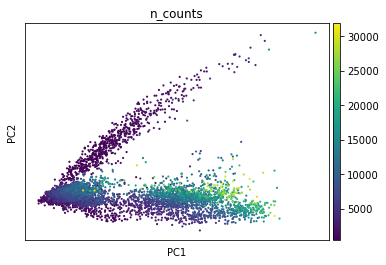

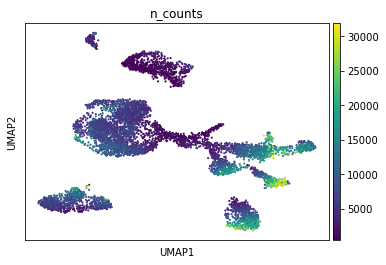

In [49]:
sc.pl.pca_scatter(adata_flt_all_man, color = 'n_counts')
#sc.pl.tsne(adata_flt_all_man, color='n_counts')
sc.pl.umap(adata_flt_all_man, color='n_counts')
#sc.pl.diffmap(adata_flt_all_man, color='n_counts', components=['1,2','1,3'])
plt.show()

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


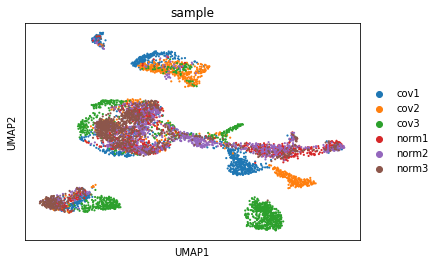

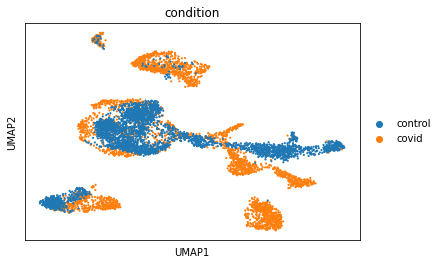

In [50]:
sc.pl.umap(adata_flt_all_man, color='sample')
sc.pl.umap(adata_flt_all_man, color='condition')

### batch correction / integration

##### harmony

In [51]:
sc.external.pp.harmony_integrate(adata_flt_all_man, 'sample')

2022-08-13 12:06:45,548 - harmonypy - INFO - Iteration 1 of 10
2022-08-13 12:06:47,923 - harmonypy - INFO - Iteration 2 of 10
2022-08-13 12:06:50,190 - harmonypy - INFO - Iteration 3 of 10
2022-08-13 12:06:52,689 - harmonypy - INFO - Iteration 4 of 10
2022-08-13 12:06:54,366 - harmonypy - INFO - Converged after 4 iterations


In [52]:
sc.pp.neighbors(adata_flt_all_man, use_rep = 'X_pca_harmony')
sc.tl.umap(adata_flt_all_man)

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


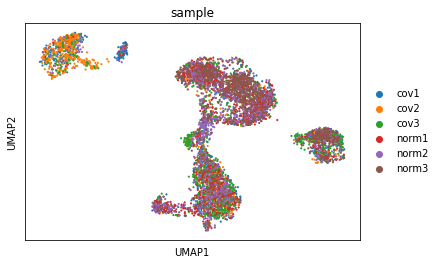

In [53]:
sc.pl.umap(adata_flt_all_man, color = 'sample')

##### ComBat

sc.pp.combat(adata_flt_all_man, key = 'sample')

sc.pp.pca(adata_flt_all_man, use_highly_variable = True)

adata_flt_all_man.obsm['X_pca'] = adata_flt_all_man.obsm['X_pca']

### visualization

In [102]:
adata_flt_all_man.obsm['X_pca']

array([[-3.4638398 , -1.0971214 ,  5.8120723 , ..., -2.1405325 ,
         0.9268635 , -0.02614491],
       [16.614752  , -3.0338347 , -2.8293664 , ...,  0.53679043,
        -1.9614011 ,  0.6742422 ],
       [14.783491  ,  3.4908035 , -1.5042831 , ...,  1.8855253 ,
         2.971075  , -1.4844939 ],
       ...,
       [-4.442333  , -4.374411  , 13.405604  , ...,  0.12006495,
         1.6386979 , -0.11574648],
       [-3.5595417 , -3.5181916 , 11.360633  , ...,  0.7958207 ,
         0.62666965,  0.37086675],
       [-6.5106025 , -1.0481502 , -2.2869163 , ...,  0.19167551,
        -2.6344507 ,  1.8367425 ]], dtype=float32)

In [103]:
sc.pp.neighbors(adata_flt_all_man)

In [93]:
#sc.tl.tsne(adata_flt_all_man, n_jobs=12)
sc.tl.umap(adata_flt_all_man)
#sc.tl.diffmap(adata_flt_all_man)
#sc.tl.draw_graph(adata_flt_all_man)

In [89]:
adata_flt_all_man

AnnData object with n_obs × n_vars = 6430 × 14047
    obs: 'sample', 'condition', 'batch', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'doublet_score', 'predicted_doublet', 'leiden_1.0', 'leiden_0.5', 'leiden_0.8', 'leiden_1.3', 'leiden_1.7', 'leiden_1.5', 'cell_types'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'sample_colors', 'scrublet', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'condition_colors', 'leiden', 'leiden_1.0_colors', 'leiden_0.5_colors', 'leiden_0.8_colors', 'leiden_1.3_colors', 'leiden_1.7_colors', 'leiden_1.5_colors', 'cell_types_colors'
    obsm: 'X_pca', 'X_umap', 'X_pca_harmony'
    varm: 'PCs'
    layers: 'raw'
    obsp: 'distances', 'connectivities'

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\AppData\Local\Temp\ipykernel_10648\3853252262.py:5: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


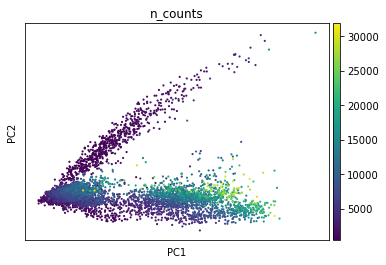

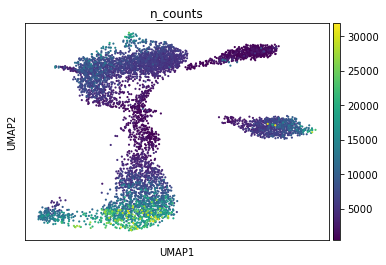

In [90]:
sc.pl.pca_scatter(adata_flt_all_man, color = 'n_counts')
#sc.pl.tsne(adata_flt_all_man, color='n_counts')
sc.pl.umap(adata_flt_all_man, color='n_counts')
#sc.pl.diffmap(adata_flt_all_man, color='n_counts', components=['1,2','1,3'])
plt.show()

## Downstream analysis

### clustering

In [71]:
sc.tl.leiden(adata_flt_all_man, key_added = 'leiden_1.0')
sc.tl.leiden(adata_flt_all_man, resolution = 0.5, key_added = 'leiden_0.5')
sc.tl.leiden(adata_flt_all_man, resolution = 0.8, key_added = 'leiden_0.8')
sc.tl.leiden(adata_flt_all_man, resolution = 1.3, key_added = 'leiden_1.3')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


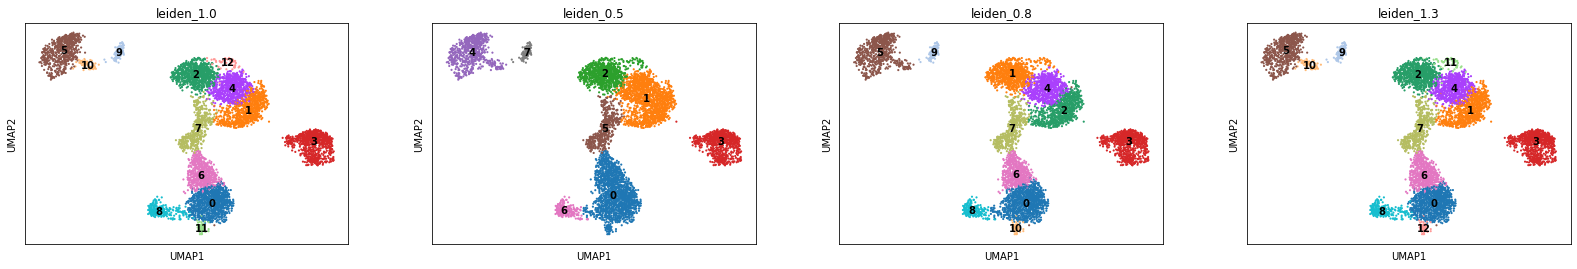

In [72]:
sc.pl.umap(adata_flt_all_man, color = ['leiden_1.0', 'leiden_0.5', 'leiden_0.8', 'leiden_1.3'], legend_loc = 'on data')

Markers | Cell Type
--- | ---
CD3E    | T cells
CD3E CD4    | CD4+ T cells
CD3E CD8A   | CD8+ T cells
GNLY, NKG7  | NK cells
MS4A1   | B cells
CD14, LYZ, CST3, MS4A7  | CD14+ Monocytes
FCGR3A, LYZ, CST3, MS4A7    | FCGR3A+  Monocytes
FCER1A, CST3 | DCs



## genes

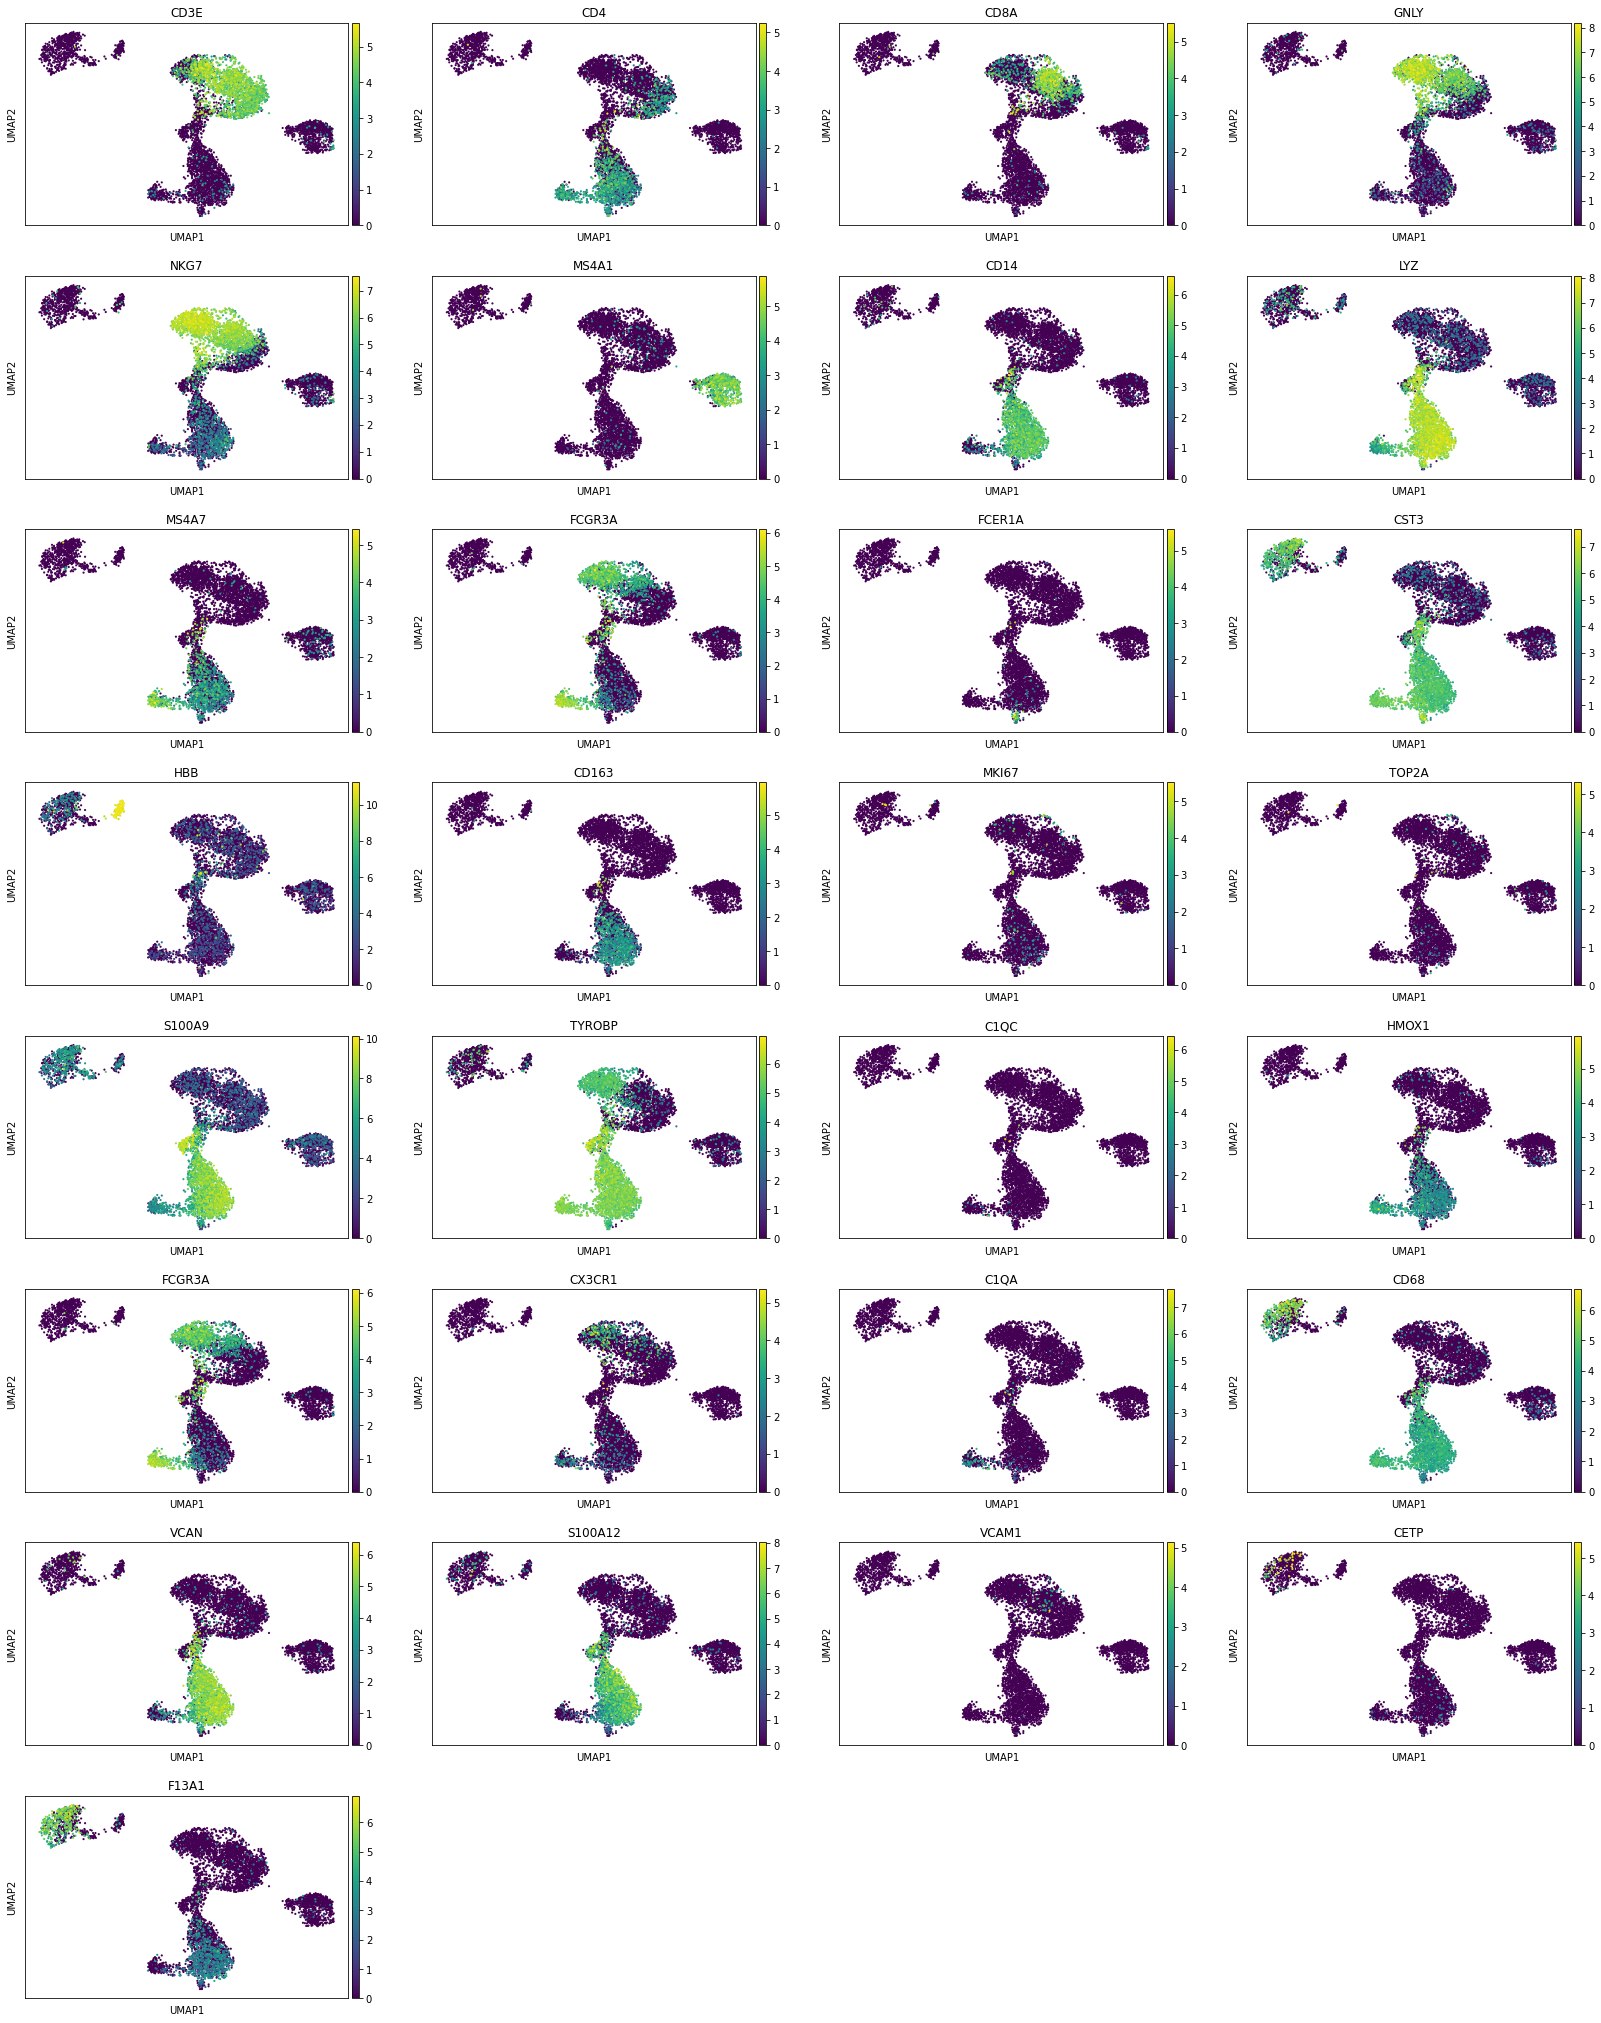

In [135]:
sc.pl.umap(adata_flt_all_man, color = ['CD3E', 
                                       'CD4',  
                                       'CD8A', 
                                       'GNLY', 
                                       'NKG7', 
                                       'MS4A1', 
                                       'CD14', 
                                       'LYZ',  
                                       'MS4A7', 
                                       'FCGR3A', 
                                       'FCER1A', 
                                       'CST3',
                                       'HBB',
                                       'CD163',
                                       'MKI67', 'TOP2A', 'S100A9', 'TYROBP', 'C1QC', 'HMOX1', 'FCGR3A', 'CX3CR1', 'C1QA', 'CD68', 'VCAN', 'S100A12',
                                       'VCAM1', 'CETP', 'F13A1'])

In [136]:
celltype_map = {
                
                '0':'CD14+ Monocytes', 
                '1':'CD4 T-cells', 
                '2':'NK cells', 
                '3':'B_cells', 
                '4':'CD8+ T cells', 
                '5':'Inflammatory monocytes', 
                '6':'Monocytes', 
                '7':'doublets', 
                '8':'FCGR3A+ Monocytes', 
                '9':'Megakaryocytes', 
                '10':'Inflammatory monocytes', 
                '11':'doublets', 
                '12':'DCs', 
}

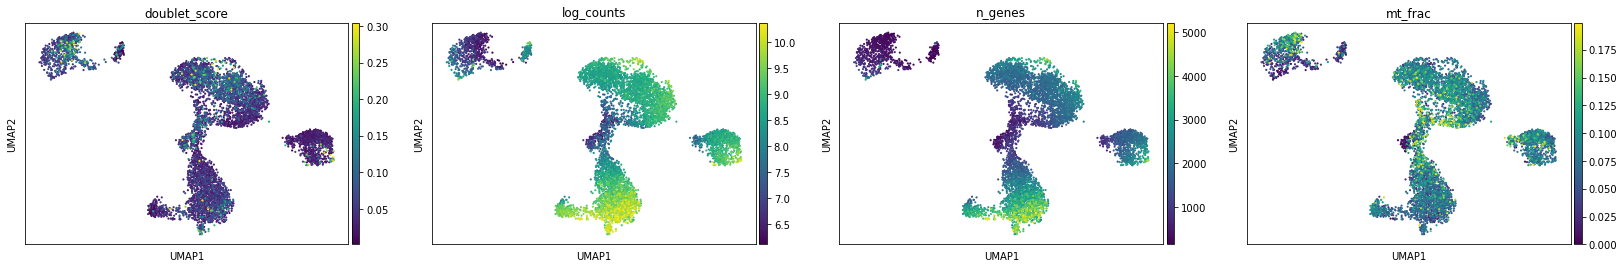

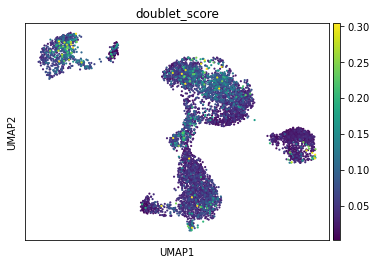

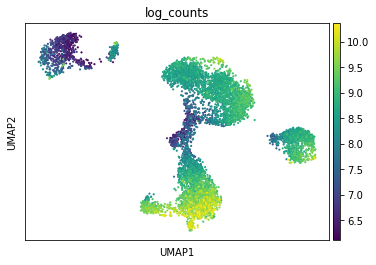

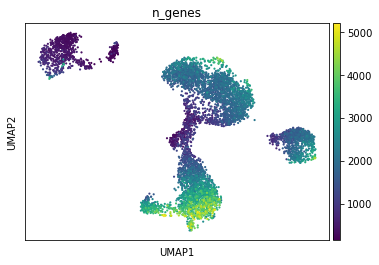

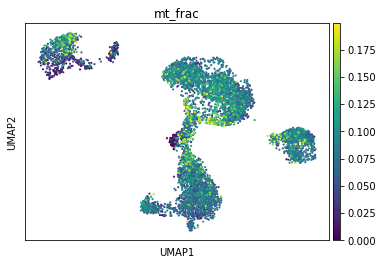

In [137]:
sc.pl.umap(adata_flt_all_man, color = ['doublet_score', 'log_counts', 'n_genes', 'mt_frac'])
sc.pl.umap(adata_flt_all_man, color = 'doublet_score')
sc.pl.umap(adata_flt_all_man, color = 'log_counts')
sc.pl.umap(adata_flt_all_man, color = 'n_genes')
sc.pl.umap(adata_flt_all_man, color = 'mt_frac')

In [138]:
adata_flt_all_man.obs['cell_types'] = adata_flt_all_man.obs['leiden_1.3'].map(celltype_map)

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


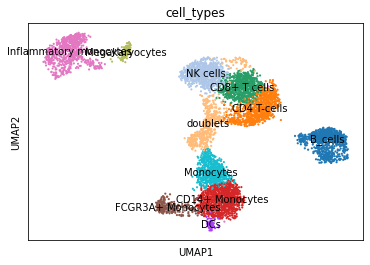

In [139]:
sc.pl.umap(adata_flt_all_man, color = 'cell_types', legend_loc = 'on data', legend_fontweight = 'light')

### compositional analysis

In [ ]:
adata_flt_all_man

In [97]:
sc.tl.embedding_density(adata_flt_all_man, basis='umap', groupby='condition')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


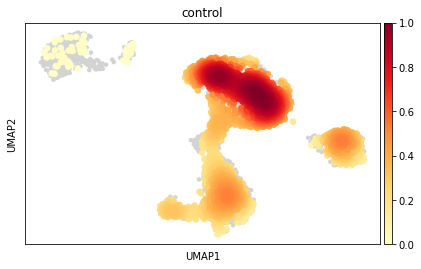

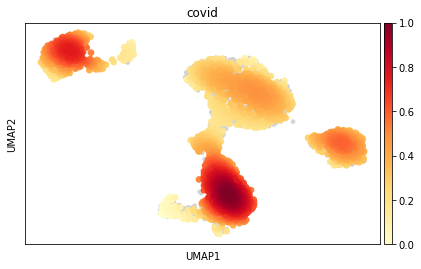

In [140]:
adata_flt_all_man.obs['condition'].value_counts()
sc.pl.embedding_density(adata_flt_all_man, basis='umap', key='umap_density_condition', group='control')
sc.pl.embedding_density(adata_flt_all_man, basis='umap', key='umap_density_condition', group='covid')

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


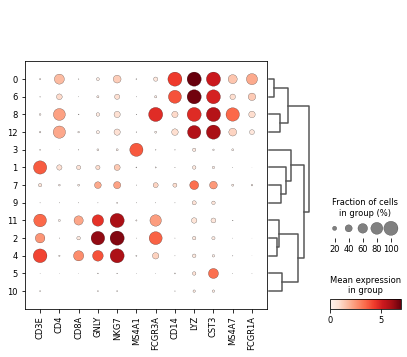

In [103]:
sc.tl.dendrogram(adata_flt_all_man, groupby = "leiden_1.3")
 
genes  = ["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","FCGR3A","CD14","LYZ","CST3","MS4A7","FCGR1A"]
sc.pl.dotplot(adata_flt_all_man, genes, groupby='leiden_1.3', dendrogram=True)


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


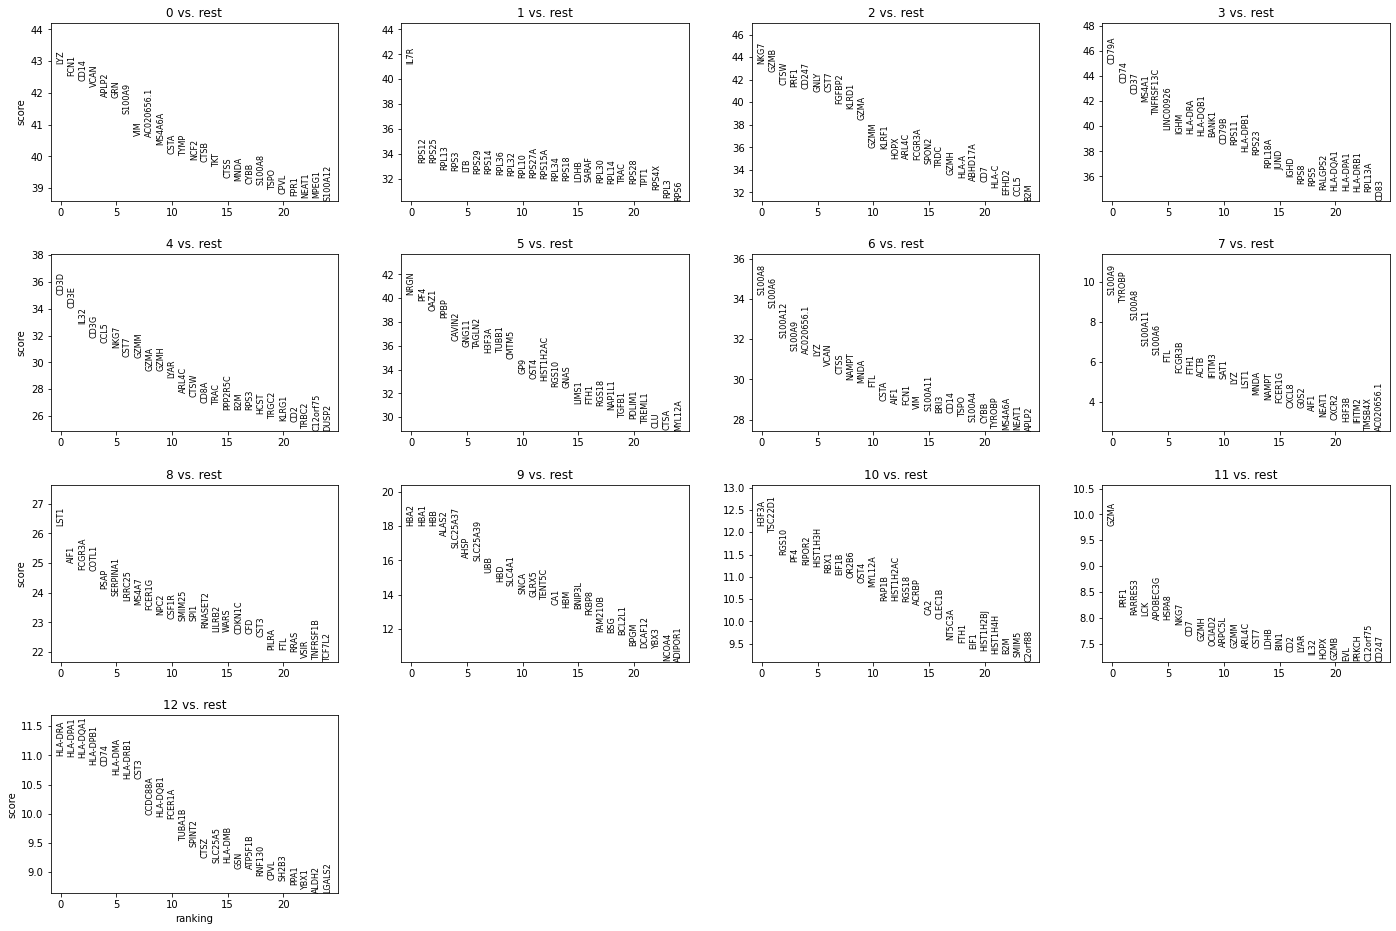

In [105]:
sc.tl.rank_genes_groups(adata_flt_all_man, 'leiden_1.3', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata_flt_all_man, n_genes=25, sharey=False, key="wilcoxon")


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


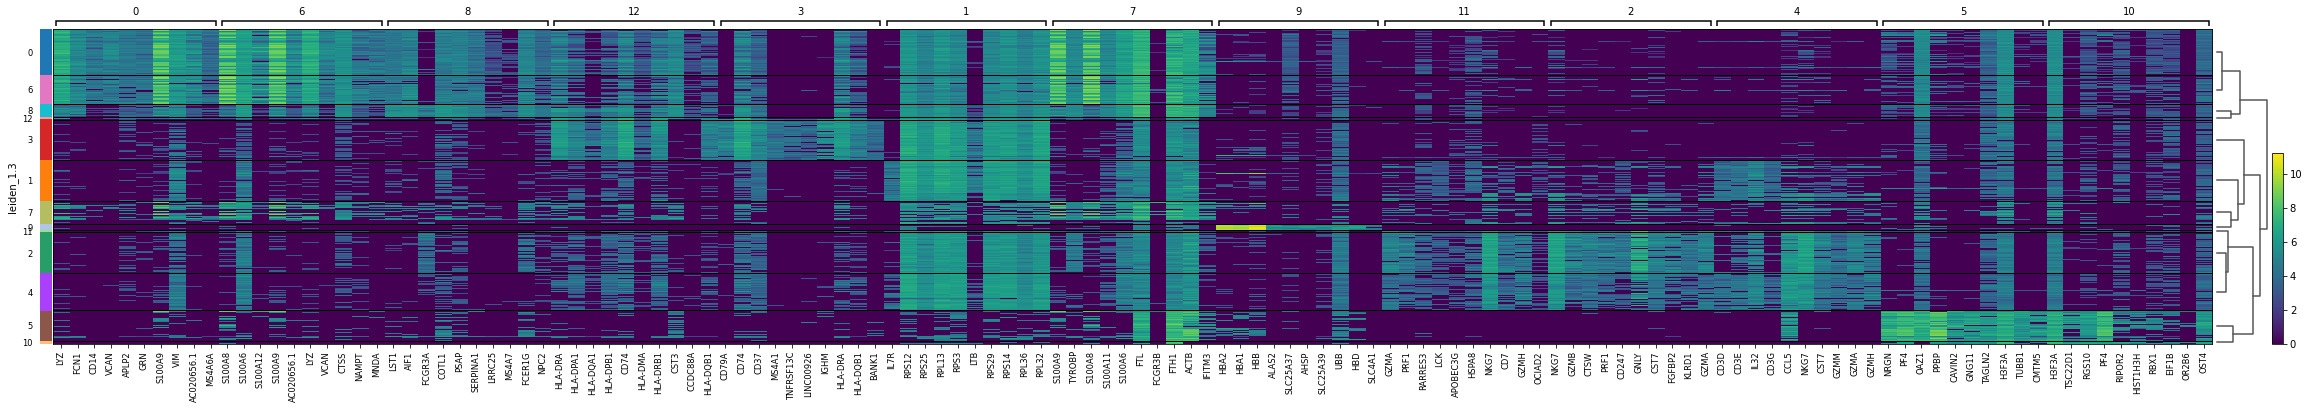

In [107]:
sc.pl.rank_genes_groups_heatmap(adata_flt_all_man, n_genes=10, key="wilcoxon", groupby="leiden_1.3", show_gene_labels=True)


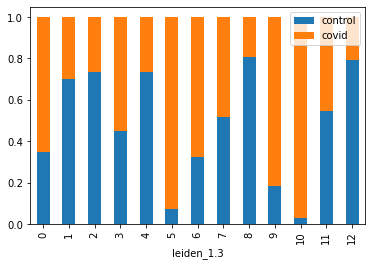

In [110]:
tmp = pd.crosstab(adata_flt_all_man.obs['leiden_1.3'],adata_flt_all_man.obs['condition'], normalize='index')
tmp.plot.bar(stacked=True).legend(loc='upper right')


In [144]:
adata_sub = adata_flt_all_man[[ct in ['Monocytes', 'Inflammatory monocytes'] for ct in adata_flt_all_man.obs['cell_types']],:]
adata_sub.obs['condition'].value_counts()


covid      1046
control     240
Name: condition, dtype: int64

C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


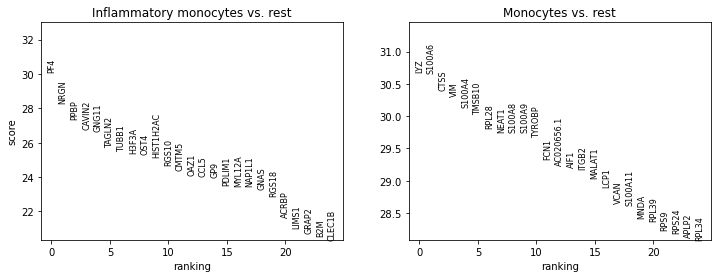

In [145]:
sc.tl.rank_genes_groups(adata_sub, 'cell_types', method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata_sub, n_genes=25, sharey=False, key="wilcoxon")


C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()
C:\Users\bende\miniconda3\envs\sc_analysis\lib\site-packages\scanpy\plotting\_utils.py:314: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  pl.show()


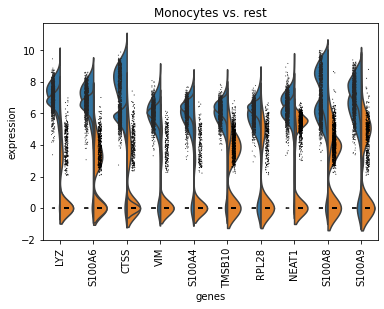

In [146]:
sc.pl.rank_genes_groups_violin(adata_sub, n_genes=10, key="wilcoxon")

In [ ]:
gene_set_names = gseapy.get_library_name(organism='Human')
glist = sc.get.rank_genes_groups_df(adata_sub, group='cell_types',
                                   key='wilcoxon', log2fc_min=0.25,
                                pval_cutoff=0.01)['names'].squeeze().str.strip().tolist()
print(len(glist))